# Pupillometry data processing
This notebook is intended to document the process to set up a pipeline for pupil diameter acquisition.

In [7]:
from scripts.conf_file_finding import try_find_conf_file
try_find_conf_file()

Local configuration file found !!, no need to run the configuration (unless configuration has changed)


In [68]:
import datajoint as dj
import os
import pathlib
import pandas as pd
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from skimage.measure import EllipseModel
from skimage.draw import ellipse_perimeter
from scipy import stats

In [9]:
dj.conn()
pupillometry_db = dj.create_virtual_module('pupillometry', 'u19_pupillometry')
acquisition_db = dj.create_virtual_module('acquisition', 'u19_acquisition')

### From which session we will get data (add a frame number as an example image)

In [83]:
frameNumber = 1000

key = dict()
key['subject_fullname'] = 'jounhong_TH_276'
key['session_date'] = '2022-04-01'

key

{'subject_fullname': 'jounhong_TH_276', 'session_date': '2022-04-01'}

### Get video & output paths

In [84]:
# Get video location
key_pupil = (acquisition_db.SessionVideo * pupillometry_db.PupillometrySession & key).fetch(as_dict=True)[0]
db_pupil_data = (pupillometry_db.PupillometryData & key).fetch(as_dict=True)[0]
pupillometry_dir = dj.config.get('custom', {}).get('pupillometry_root_data_dir',None)
if pupillometry_dir is None:
    raise Exception('pupillometry_root_data_dir not found in config, run initial_conf.py again')
pupillometry_raw_dir = pupillometry_dir[0]
videoPath = pathlib.Path(pupillometry_raw_dir, key_pupil['remote_path_video_file'])
print('videoPath', videoPath)

# Get output location
pupillometry_processed_dir = pupillometry_dir[1]
output_dir = pathlib.Path(pupillometry_processed_dir,pathlib.Path(key_pupil['remote_path_video_file']).parent)

#Find h5 files (output from deeplabcut)
h5_files = glob.glob(str(output_dir) + '/*.h5')
if len(h5_files) != 1:
    raise Exception('Didn''t find any h5 files after deeplabcut analyze_video')
else:
    h5_files = h5_files[0]
print('h5_files', h5_files)

videoPath /mnt/cup/braininit/Data/Raw/video_pupillometry/jounhong/jounhong_TH_276/20220401_g0/jounhong_TH_276_20220401_g0.mj2
h5_files /mnt/cup/braininit/Data/Processed/video_pupillometry/jounhong/jounhong_TH_276/20220401_g0/jounhong_TH_276_20220401_g0DLC_resnet101_Pupillometry2Apr7shuffle1_1030000.h5


In [85]:
db_pupil_data['pupil_diameter'][frameNumber]

32.526761997435564

### Read videoFrame & h5 file

In [86]:
# Read output file
labels = pd.read_hdf(h5_files)


cap = cv2.VideoCapture(str(videoPath))

# count the number of frames 
frames = cap.get(cv2.CAP_PROP_FRAME_COUNT) 

print('total # of frames', int(frames))
print('Length output deeplabcut', labels.shape[0])

# Get total number of frames
totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
# Set frame position
cap.set(cv2.CAP_PROP_POS_FRAMES,frameNumber)

ret, frame = cap.read()
name = str(frameNumber) + '.jpg'
cv2.imwrite(name, frame)

cap.release()
cv2.destroyAllWindows()

total # of frames 109273
Length output deeplabcut 109273


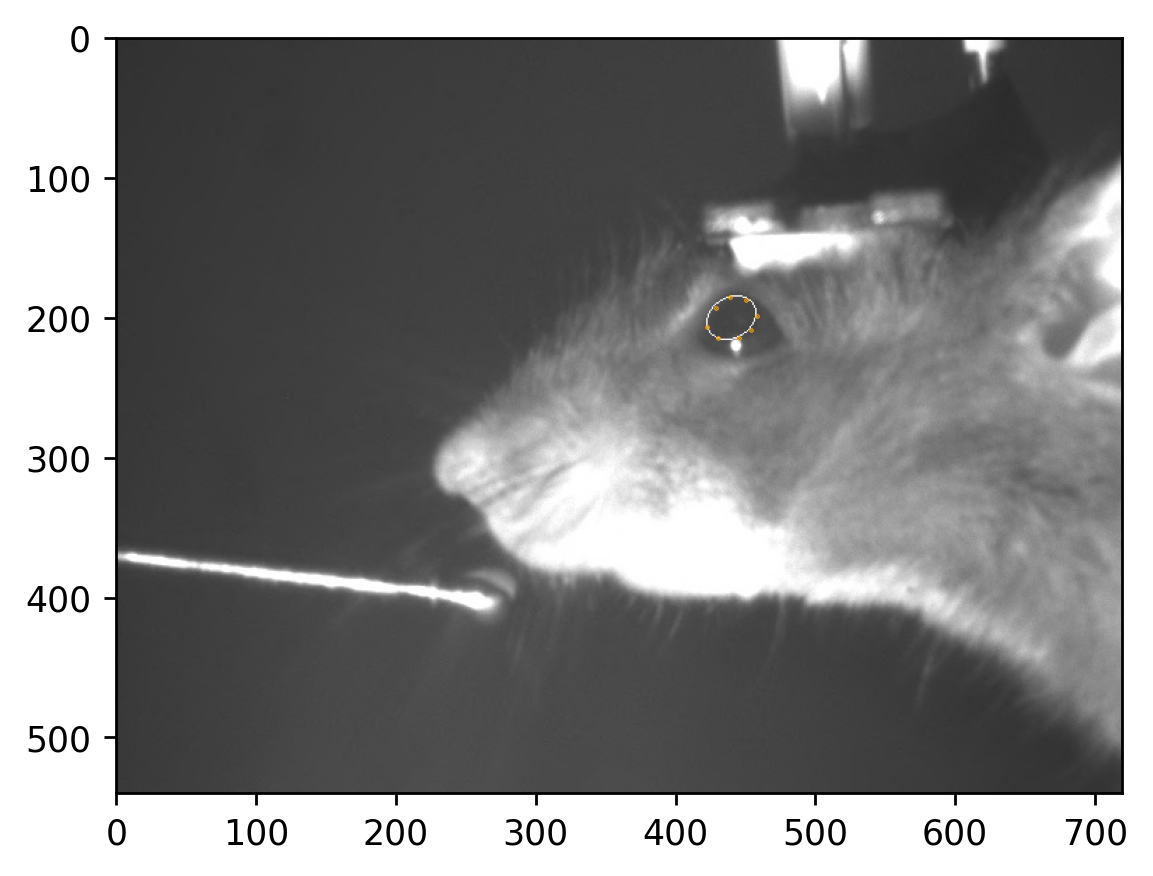

In [87]:


# Take a subset from the data
subset = labels.loc[frameNumber]
# Get the pupil markers (0 to 8) from the multiindex array obtained from deeplabcut
x = subset.xs('x', level='coords').to_numpy()[0:8]
y = subset.xs('y', level='coords').to_numpy()[0:8]
xy = np.column_stack((x,y))

# Estimate an ellipse based on the points generated around the pupil, this is enough to get an estimate of the pupil area in pixels
ellipse = EllipseModel()
ellipse.estimate(xy)

# Validate by ploting the points and the fitting ellipse on the image from the video
fig, ax = plt.subplots()
plt.rcParams['figure.dpi'] = 250
img = cv2.imread(str(frameNumber) + '.jpg')
ax.scatter(xy[:,0], xy[:,1], s=0.1, color='orange')
# Draw the ellipse on the original image
cy, cx = ellipse_perimeter(int(ellipse.params[1]), int(ellipse.params[0]), int(ellipse.params[3]), int(ellipse.params[2]), ellipse.params[4])
img[cy, cx] = 255
ax.imshow(img)

# Calculate the area of the elipse
ellipseArea = np.pi * ellipse.params[2] * ellipse.params[3]

In [88]:
df = pd.DataFrame(db_pupil_data['pupil_diameter'], columns=['PupilDiameter'])

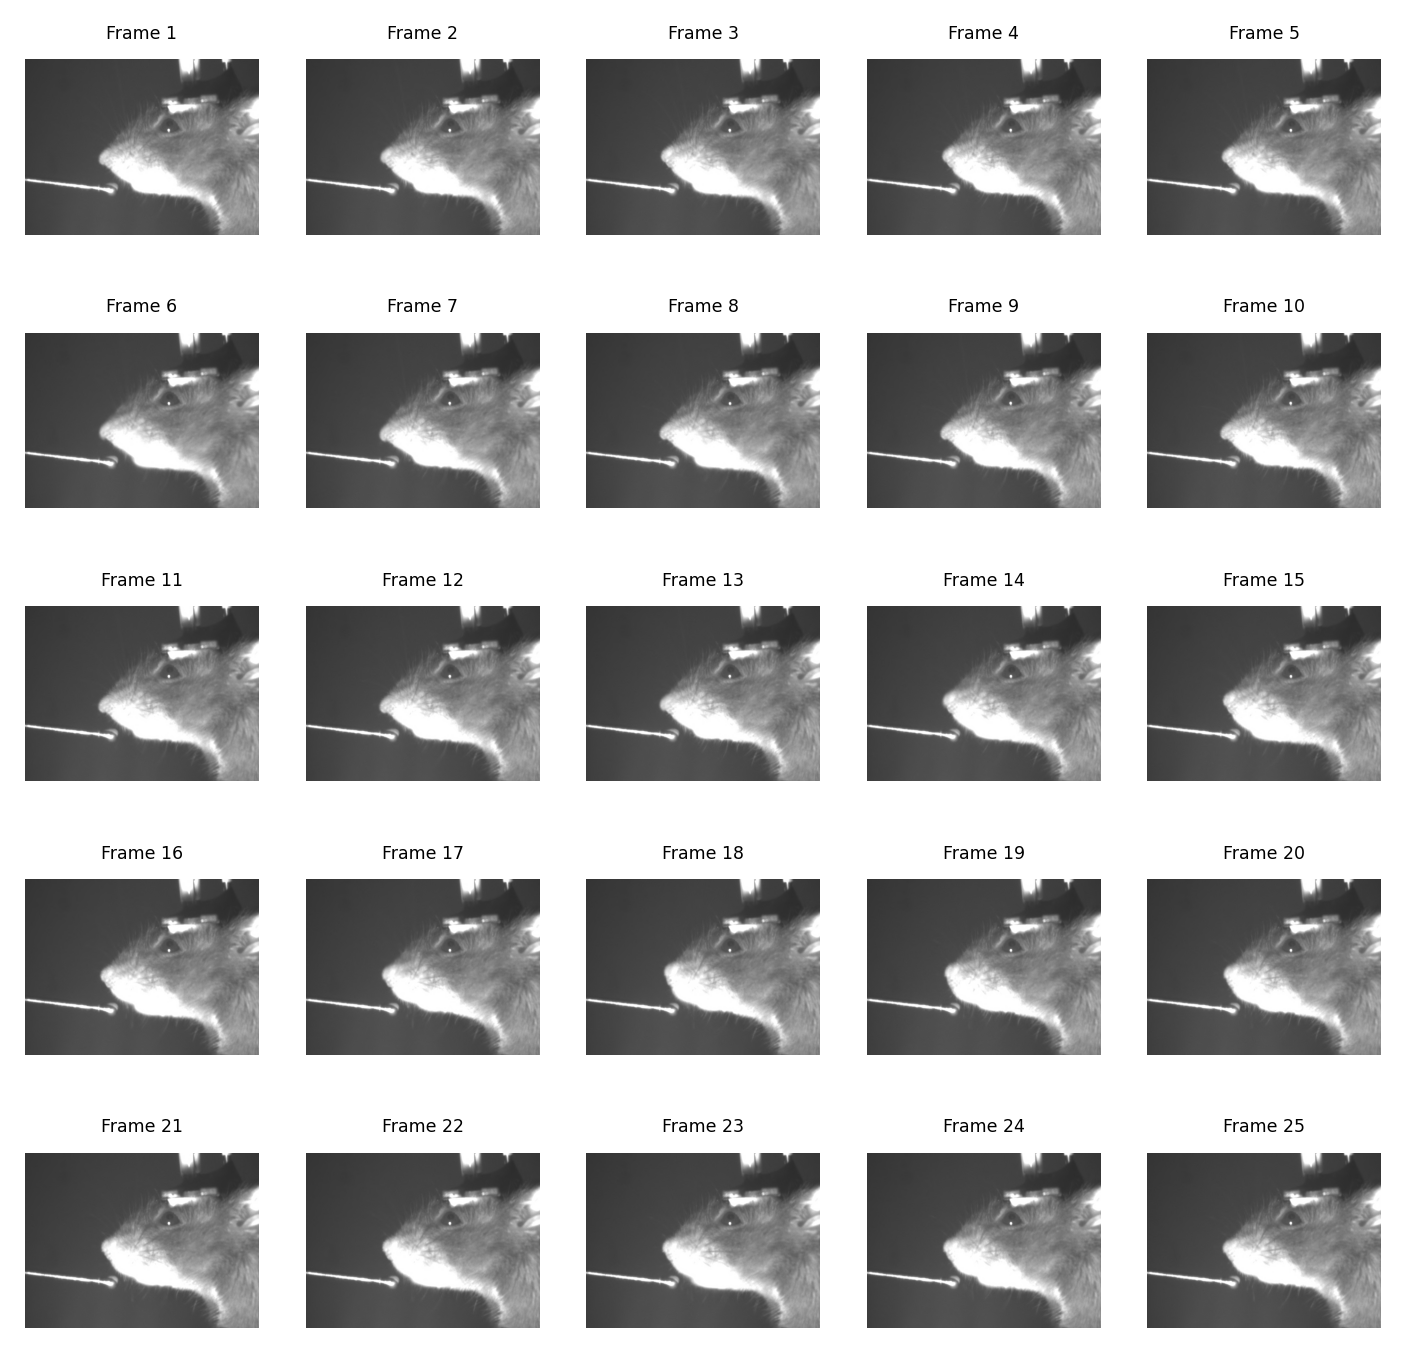

In [104]:

# Get a boolean array where true correspond to the frame with an outlier diameter
zscore = np.abs(stats.zscore(df, nan_policy='omit'))
outlierFlags = np.abs(zscore) > 2
outlierFlags = outlierFlags.rename(columns={outlierFlags.columns[0]: "OutlierFlag"})

# Get the list of outlier frames
from itertools import compress
outlierFrames = list(compress(range(len(outlierFlags)), outlierFlags['OutlierFlag']))


# Retrieve an outlier frames sample from the video for visual inspection
cap = cv2.VideoCapture(str(videoPath))
fig = plt.figure(figsize=(7, 7))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    # Get total number of frames
    totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    # Set frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES,outlierFrames[i])
    ret, frame = cap.read()

    fig.add_subplot(rows, columns, i)
    plt.title("Frame " + str(outlierFrames[i]), fontsize=5)
    plt.imshow(frame)
    plt.axis('off')
plt.show()
cap.release()
cv2.destroyAllWindows()


In [98]:
len(outlierFrames)

3589

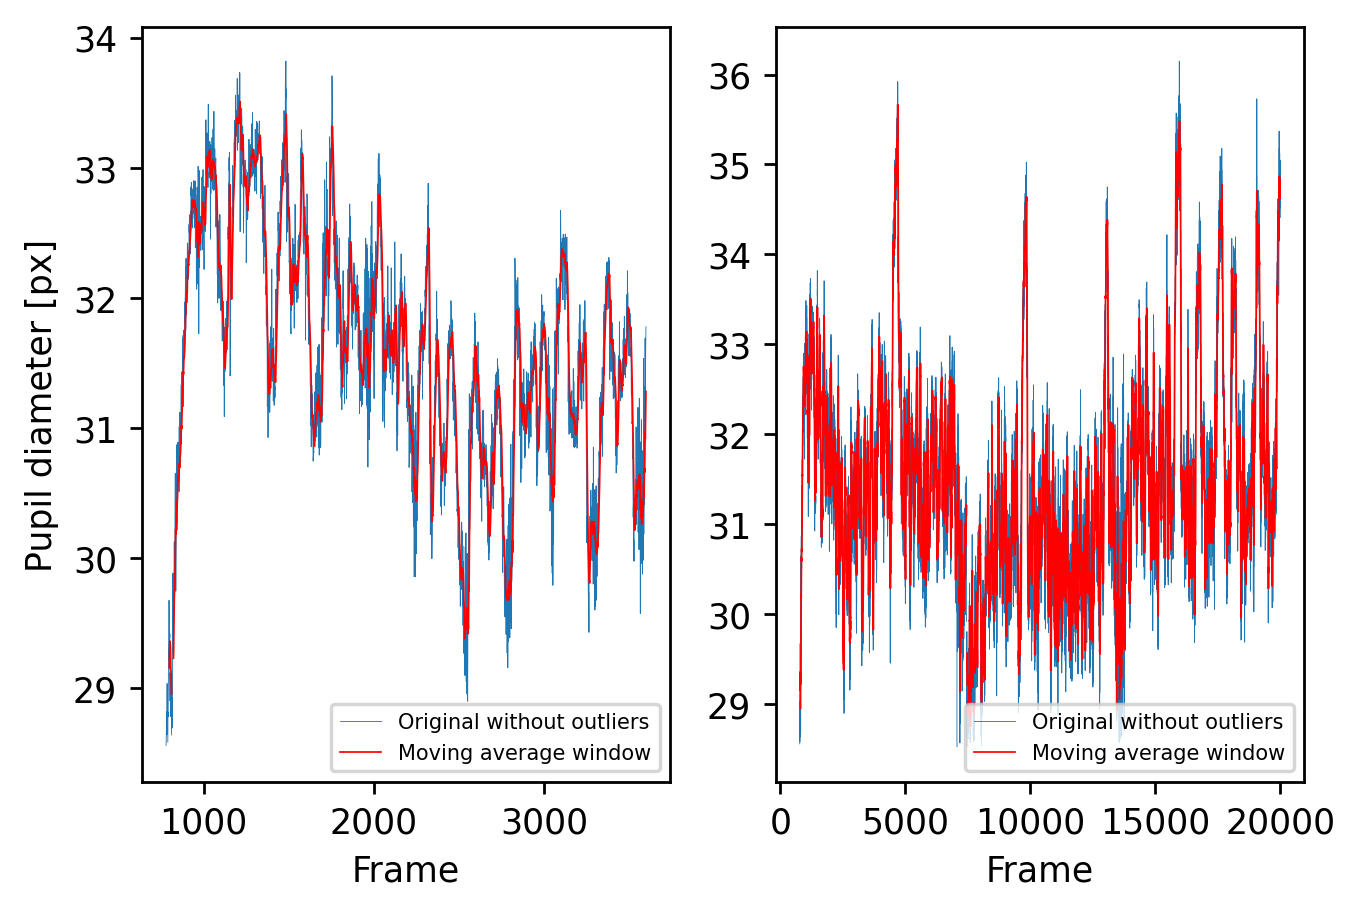

In [106]:
# Concatenate outlier flags array to remove outliers from pupil diameter array
temp = pd.concat([df, outlierFlags], axis=1)
temp.loc[temp['OutlierFlag']==True, 'PupilDiameter'] = None
pupilDiameter = temp['PupilDiameter']

# This might be better to leave open for the experimenter.
# Replace the outlier diameter data using a cubic spline interpolator
# pupilDiameter = temp['PupilDiameter'].interpolate(method='spline', order=3, s=0)

fig, (ax1, ax2) = plt.subplots(1,2)
# plt.rcParams['figure.dpi'] = 250

ax1.plot(pupilDiameter[0:3600], linewidth=0.25)
# Filter by using a moving average window of 10 samples
ax1.plot(pupilDiameter[0:3600].rolling(10).mean(), linewidth=0.5, color='red')
ax1.set_xlabel('Frame')
ax1.set_ylabel('Pupil diameter [px]')
ax1.legend(['Original without outliers', 'Moving average window'], loc=4, prop={'size': 6})

ax2.plot(pupilDiameter[0:20000], linewidth=0.25)
# Filter by using a moving average window of 10 samples
ax2.plot(pupilDiameter[0:20000].rolling(10).mean(), linewidth=0.5, color='red')
ax2.set_xlabel('Frame')
ax2.legend(['Original without outliers', 'Moving average window'], loc=4, prop={'size': 6})
#fig.savefig('test.eps', format='eps')

In [76]:
outlierFrames

[]